In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'lgg-mri-segmentation' dataset.
Path to dataset files: /kaggle/input/lgg-mri-segmentation


In [2]:
import os
path = "/kaggle/input/lgg-mri-segmentation/kaggle_3m"

In [3]:
from glob import glob
all_images = sorted(glob(os.path.join(path, "*", "*.tif")))
all_masks = [f for f in all_images if "_mask" in f]
all_images = [f for f in all_images if "_mask" not in f]
print(f"Total MRI images: {len(all_images)}")
print(f"Total masks: {len(all_masks)}")

Total MRI images: 3929
Total masks: 3929


In [4]:
def get_mask_path(img_path):
    return img_path.replace(".tif", "_mask.tif")


In [5]:
pairs = [(img, get_mask_path(img)) for img in all_images if os.path.exists(get_mask_path(img))]

print(f"Total image–mask pairs: {len(pairs)}")

Total image–mask pairs: 3929


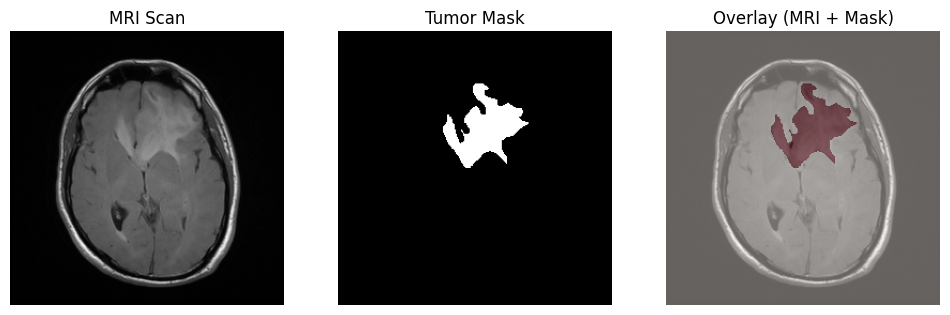

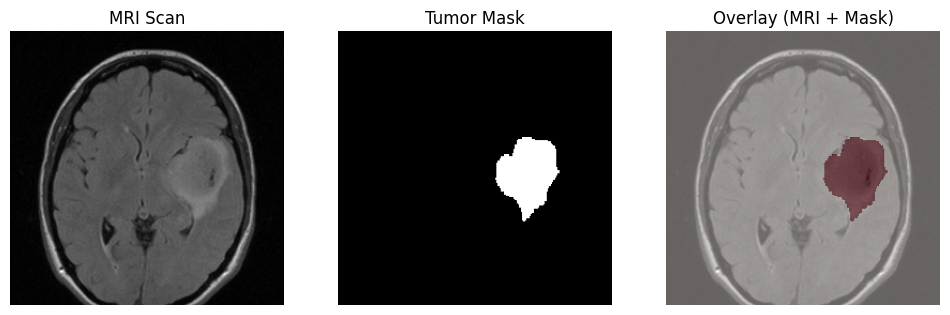

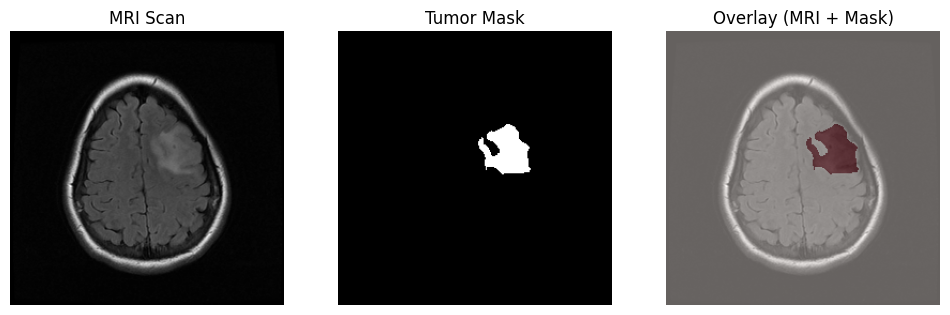

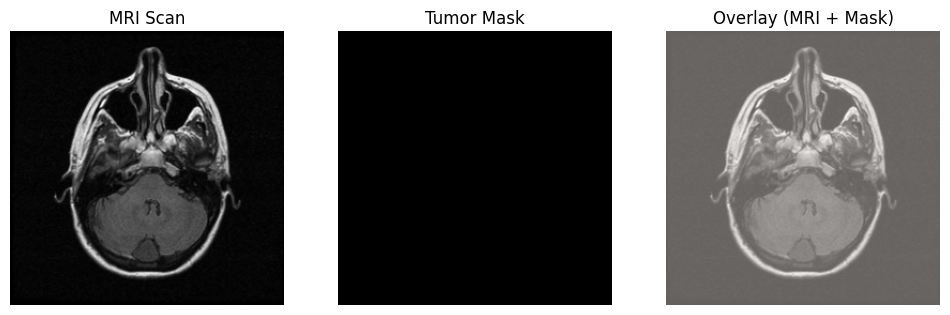

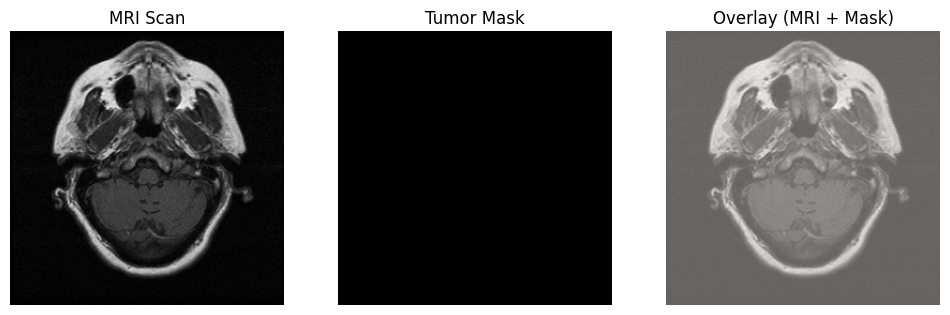

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
import random

# Pick random pairs to visualize
sample_pairs = random.sample(pairs, 5)

for img_path, mask_path in sample_pairs:
    # Open image and mask
    img = Image.open(img_path).convert("L")   # MRI is grayscale
    mask = Image.open(mask_path).convert("L") # Mask is also grayscale

    # Create figure
    plt.figure(figsize=(12,4))

    # Show original MRI
    plt.subplot(1,3,1)
    plt.imshow(img, cmap="gray")
    plt.title("MRI Scan")
    plt.axis("off")

    # Show mask
    plt.subplot(1,3,2)
    plt.imshow(mask, cmap="gray")
    plt.title("Tumor Mask")
    plt.axis("off")

    # Overlay mask on MRI
    plt.subplot(1,3,3)
    plt.imshow(img, cmap="gray")
    plt.imshow(mask, cmap="Reds", alpha=0.4)  # Transparent red overlay
    plt.title("Overlay (MRI + Mask)")
    plt.axis("off")

    plt.show()


In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

IMG_SIZE = 128
BATCH_SIZE = 16
EPOCHS = 50

def load_and_preprocess(img_path, mask_path):
    img = Image.open(img_path).convert("L").resize((IMG_SIZE, IMG_SIZE))
    mask = Image.open(mask_path).convert("L").resize((IMG_SIZE, IMG_SIZE))

    # Convert to numpy
    img = np.array(img, dtype=np.float32) / 255.0   # normalize [0,1]
    mask = np.array(mask, dtype=np.float32) / 255.0 # normalize [0,1]

    # Expand dims for channel (needed by CNN)
    img = np.expand_dims(img, axis=-1)
    mask = np.expand_dims(mask, axis=-1)

    return img, mask


In [17]:
images, masks = [], []
for img_path, mask_path in pairs:
    img, mask = load_and_preprocess(img_path, mask_path)
    images.append(img)
    masks.append(mask)

images = np.array(images)
masks = np.array(masks)

print("Images shape:", images.shape)
print("Masks shape:", masks.shape)

Images shape: (3929, 128, 128, 1)
Masks shape: (3929, 128, 128, 1)


In [18]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

In [19]:
X_test, X_valid, y_test, y_valid = train_test_split(
    X_val, y_val, test_size=0.5, random_state=42
)

In [20]:
def unet_model(input_size=(IMG_SIZE, IMG_SIZE, 1)):
    inputs = layers.Input(input_size)

    # Encoder (downsampling)
    c1 = layers.Conv2D(16, (3,3), activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(16, (3,3), activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(32, (3,3), activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(32, (3,3), activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(64, (3,3), activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(64, (3,3), activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    c4 = layers.Conv2D(128, (3,3), activation="relu", padding="same")(p3)
    c4 = layers.Conv2D(128, (3,3), activation="relu", padding="same")(c4)
    p4 = layers.MaxPooling2D(pool_size=(2,2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(256, (3,3), activation="relu", padding="same")(p4)
    c5 = layers.Conv2D(256, (3,3), activation="relu", padding="same")(c5)

    # Decoder (upsampling)
    u6 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, (3,3), activation="relu", padding="same")(u6)
    c6 = layers.Conv2D(128, (3,3), activation="relu", padding="same")(c6)

    u7 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, (3,3), activation="relu", padding="same")(u7)
    c7 = layers.Conv2D(64, (3,3), activation="relu", padding="same")(c7)

    u8 = layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, (3,3), activation="relu", padding="same")(u8)
    c8 = layers.Conv2D(32, (3,3), activation="relu", padding="same")(c8)

    u9 = layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(16, (3,3), activation="relu", padding="same")(u9)
    c9 = layers.Conv2D(16, (3,3), activation="relu", padding="same")(c9)

    outputs = layers.Conv2D(1, (1,1), activation="sigmoid")(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [21]:
model = unet_model()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │        160 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │      2,320 │ conv2d_19[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │      9,248 │ conv2d_21[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_23[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 16, 16,    │    147,584 │ conv2d_25[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 8, 8, 128) │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 8, 8, 256) │    295,168 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 8, 8, 256) │    590,080 │ conv2d_27[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 16, 16,    │    131,200 │ conv2d_28[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_26[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,940,817 (7.40 MB)

 Trainable params: 1,940,817 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)

Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 24s 73ms/step - accuracy: 0.9860 - loss: 0.1684 - val_accuracy: 0.9890 - val_loss: 0.0339
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9876 - loss: 0.0362 - val_accuracy: 0.9890 - val_loss: 0.0336
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.9879 - loss: 0.0360 - val_accuracy: 0.9890 - val_loss: 0.0336
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9880 - loss: 0.0346 - val_accuracy: 0.9890 - val_loss: 0.0306
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9873 - loss: 0.0356 - val_accuracy: 0.9890 - val_loss: 0.0308
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9872 - loss: 0.0330 - val_accuracy: 0.9890 - val_loss: 0.0329
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.9872 - loss: 0.0327 - val_accuracy: 0.9890 - val_loss: 0.0283
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9873 - loss: 0.0313 - val_a

In [24]:
model.evaluate(X_test,y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9940 - loss: 0.0099


[0.009942415170371532, 0.9937403798103333]

In [23]:
def visualize_predictions(X, y, model, n_samples=5, threshold=0.5):

    idxs = random.sample(range(len(X)), n_samples)

    for i, idx in enumerate(idxs):
        img = X[idx]
        true_mask = y[idx]

        # Predict mask
        pred_mask = model.predict(np.expand_dims(img, axis=0))[0]
        pred_mask = (pred_mask > threshold).astype(np.float32)

        # Compute Dice and IoU
        y_true_f = true_mask.flatten()
        y_pred_f = pred_mask.flatten()
        intersection = np.sum(y_true_f * y_pred_f)
        dice = (2. * intersection + 1e-6) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1e-6)
        iou = (intersection + 1e-6) / (np.sum(y_true_f) + np.sum(y_pred_f) - intersection + 1e-6)

        # Plot
        plt.figure(figsize=(12,4))

        plt.subplot(1,3,1)
        plt.imshow(img.squeeze(), cmap="gray")
        plt.title(f"MRI #{i+1}")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(true_mask.squeeze(), cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(img.squeeze(), cmap="gray")
        plt.imshow(pred_mask.squeeze(), cmap="Reds", alpha=0.4)
        plt.title(f"Predicted Mask\nDice: {dice:.4f}, IoU: {iou:.4f}")
        plt.axis("off")

        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step


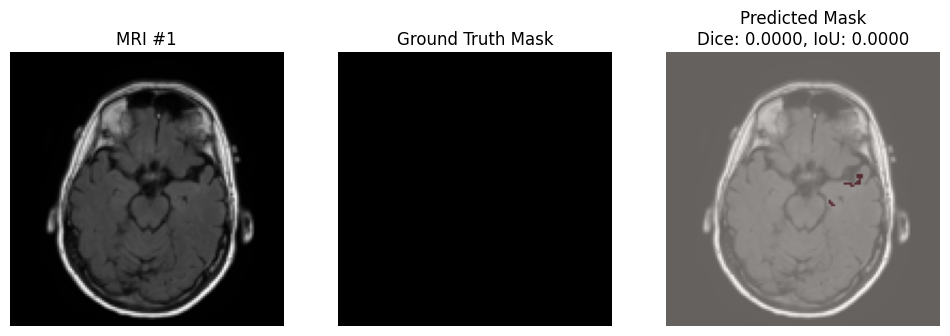

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


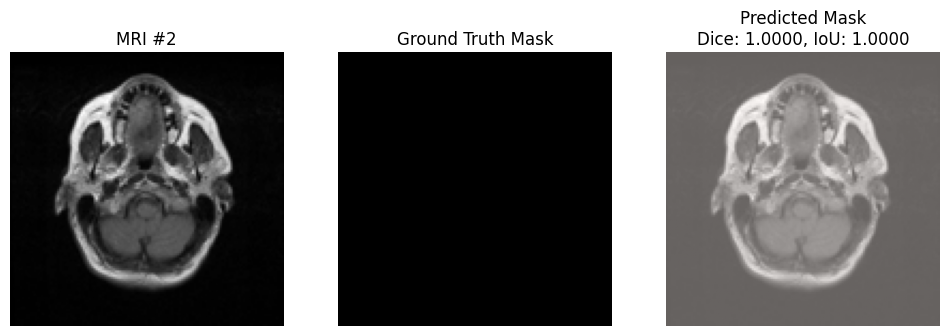

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


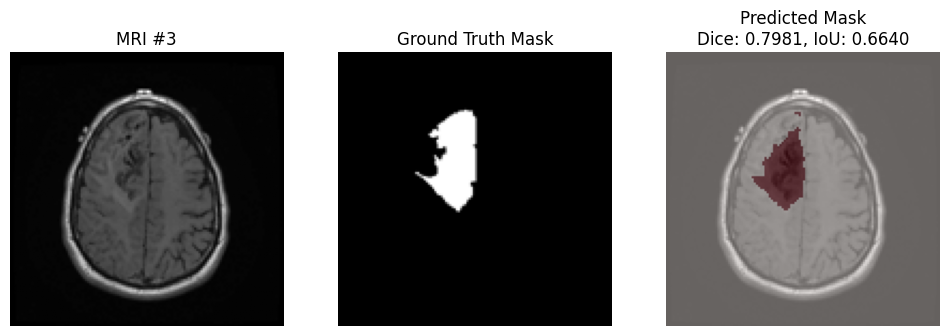

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


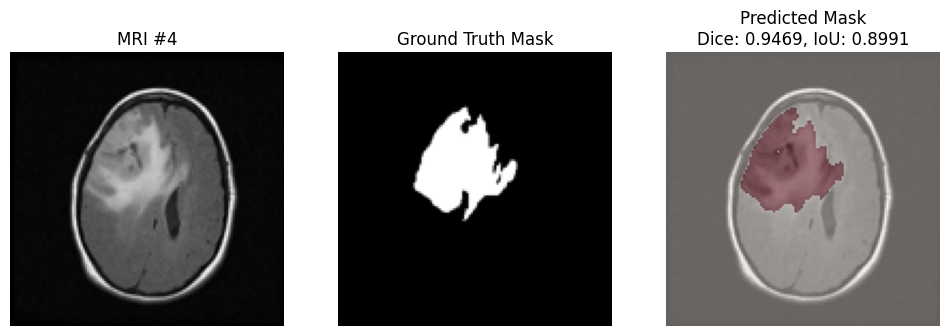

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


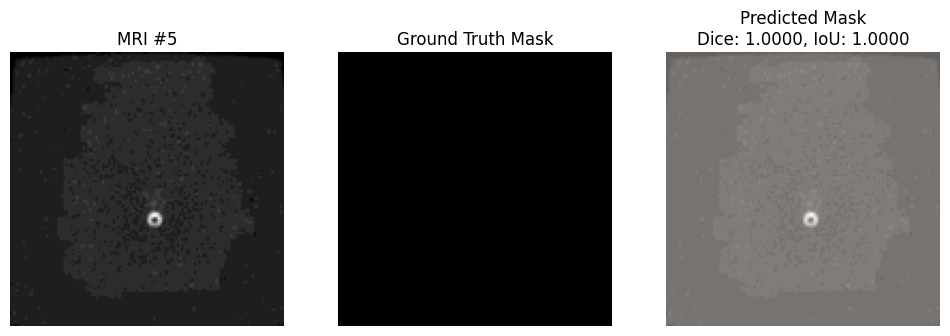

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


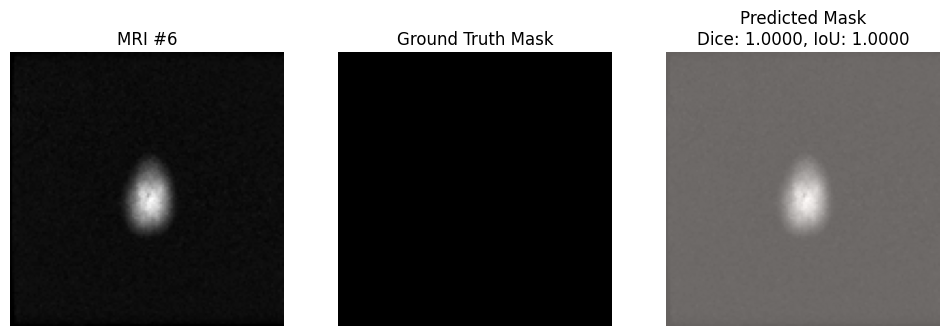

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


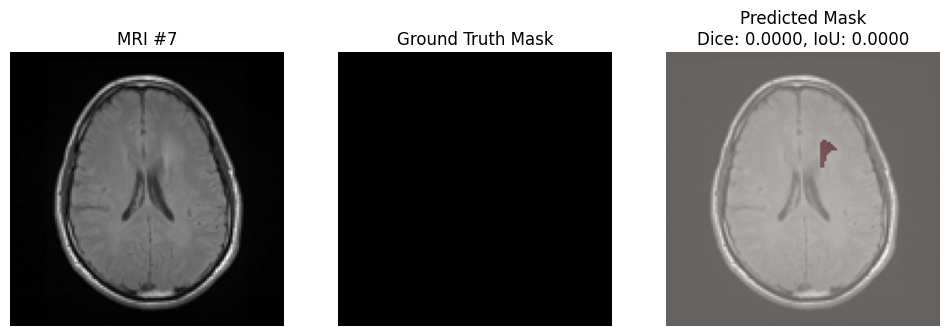

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


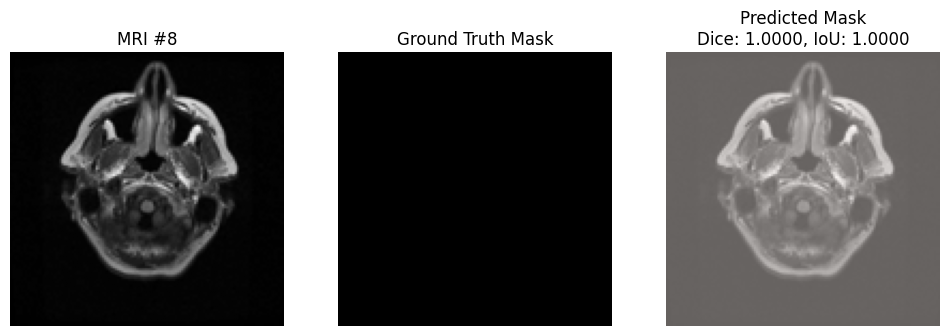

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


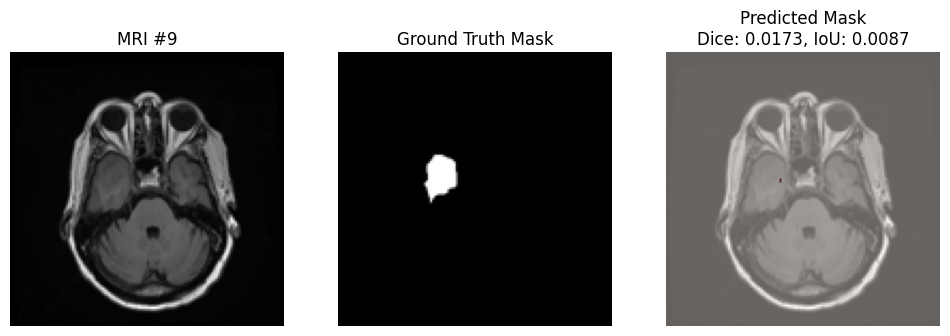

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


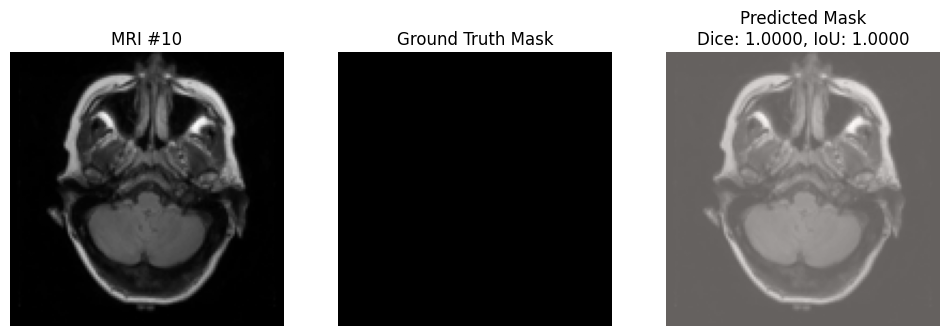

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


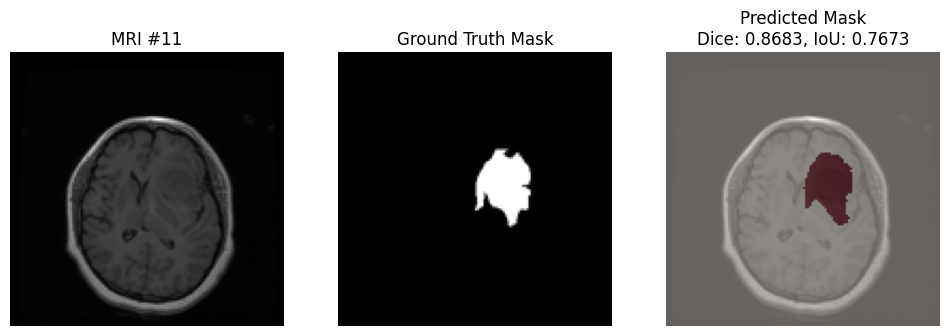

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


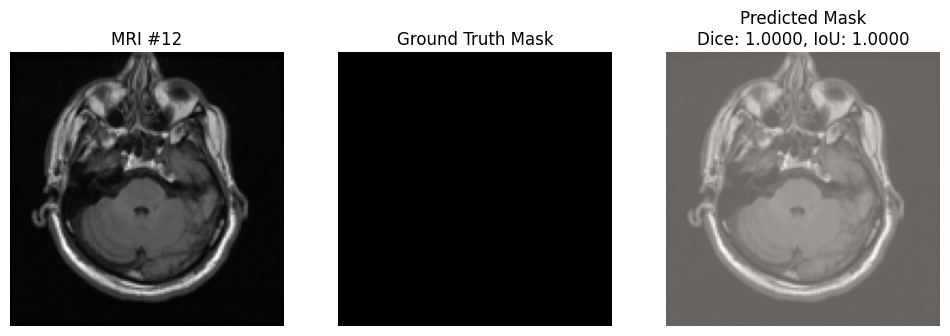

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


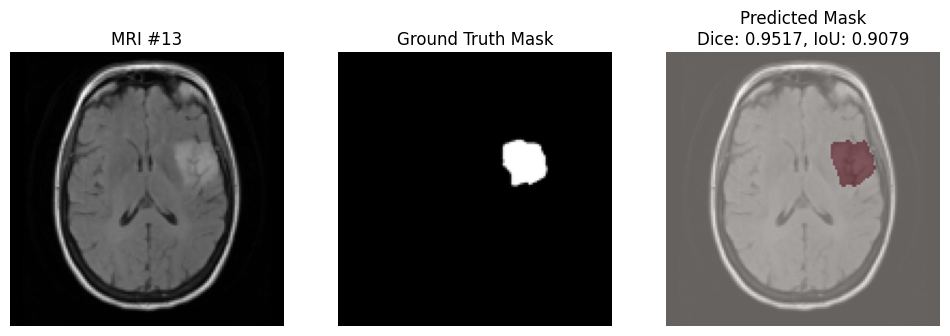

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


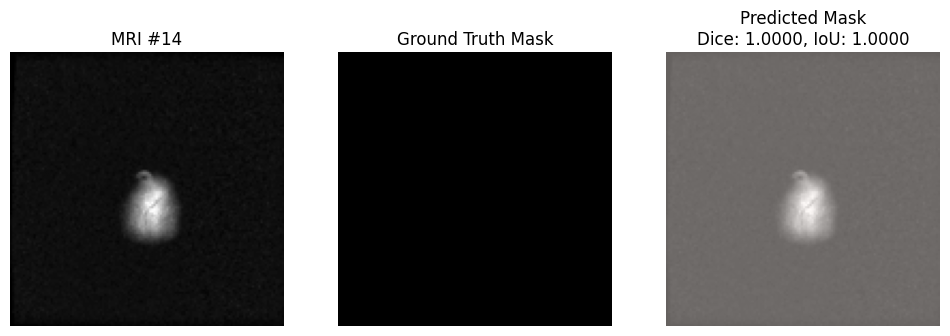

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


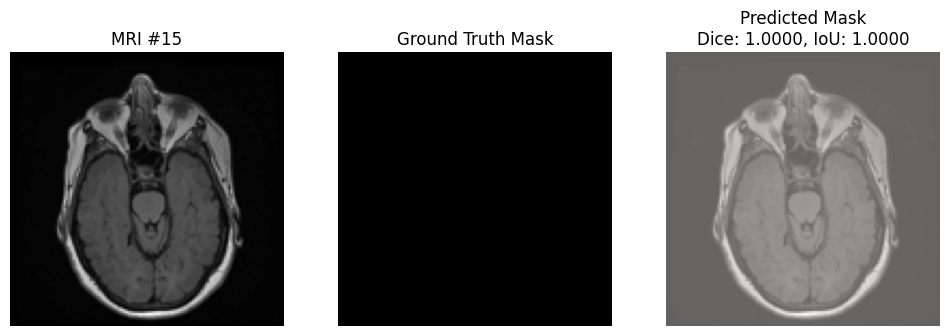

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


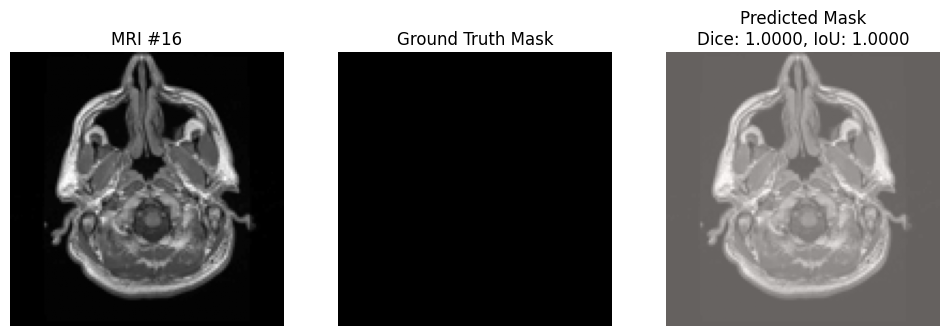

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


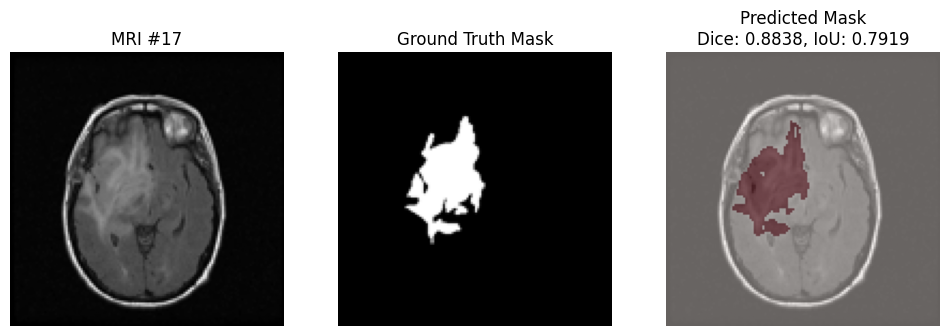

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


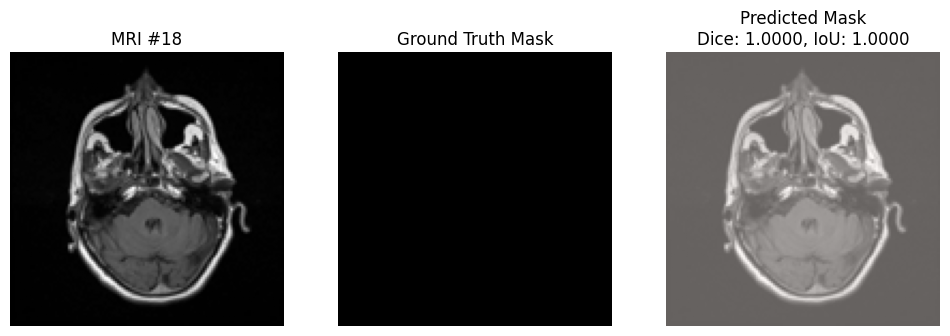

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


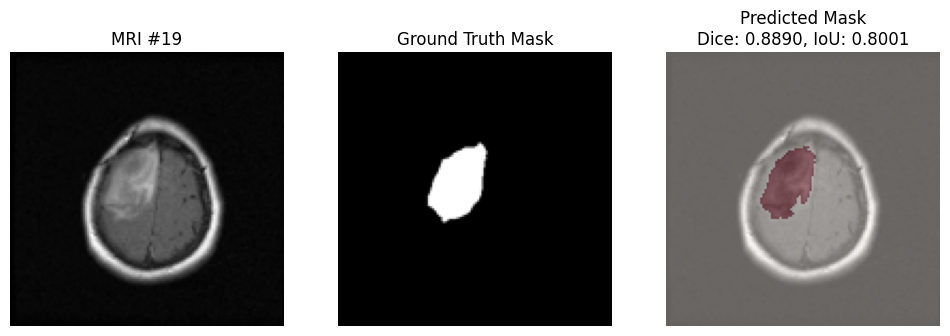

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


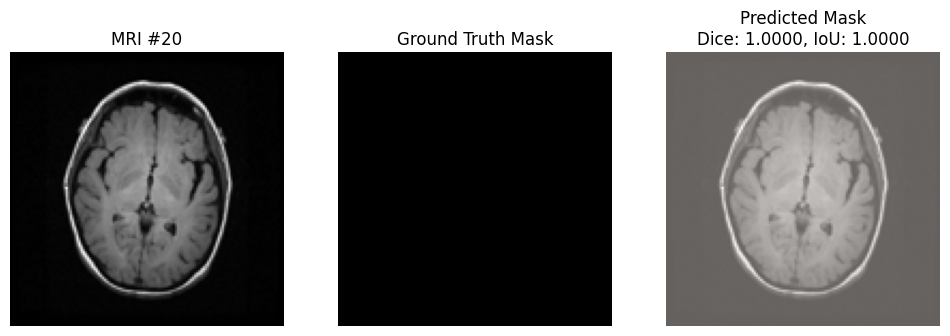

In [25]:
visualize_predictions(X_test, y_test, model, n_samples=20)

In [26]:
model.save("SegmentMRI.keras")